# Alcohol and Gaming Commission of Ontario 

Senior Data Scientist Technical Assessment

In [ ]:
Derya Kici, June 1, 2023

In [1]:
# !pip install imblearn

Develop a predictive model using the given dataset on Chicago restaurant inspections. The aim is to identify establishments at a higher risk of violations

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from collections import Counter
from multiprocessing import Pool
from random import sample
import time

In [4]:
import sklearn
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

In [5]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [9]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


# Load Data

In [10]:
# data = pd.read_csv("C:\\Users\\derya\\Desktop\\AGCO Pre-Interview Assessment\\data\\Food Inspections and Violations.csv")
data = pd.read_csv("/content/gdrive/MyDrive/AGCO Pre-Interview Assessment/data/Food Inspections and Violations.csv")
data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2079132,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517328.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,08/28/2017,License,Pass,NaN,41.853651,-87.620534,"(41.853650885040594, -87.62053358114167)"
1,2079129,JET'S PIZZA,JET'S PIZZA,2522268.0,Restaurant,Risk 2 (Medium),1025 W MADISON ST,CHICAGO,IL,60607.0,08/28/2017,License,Not Ready,NaN,41.881572,-87.653052,"(41.88157249576794, -87.65305233593274)"
2,2079125,ROOM 1520,ROOM 1520,2446638.0,Special Event,Risk 3 (Low),301 N JUSTINE ST,CHICAGO,IL,60607.0,08/28/2017,License Re-Inspection,Not Ready,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,41.886577,-87.665328,"(41.88657652150854, -87.66532812140231)"
3,2079123,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517338.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,08/28/2017,License,Pass,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.853651,-87.620534,"(41.853650885040594, -87.62053358114167)"
4,2079105,CHARTWELLS,CICS WEST BELDEN CAMPUS,2549079.0,CHARTER SCHOOL,Risk 1 (High),2245 N MCVICKER AVE,CHICAGO,IL,60639.0,08/28/2017,License Re-Inspection,Pass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.921675,-87.776711,"(41.921675488910864, -87.7767113569357)"


In [11]:
data = data.dropna()
len(data[data["Violations"].isna()])

0

In [12]:
data.isnull().sum()

Inspection ID      0
DBA Name           0
AKA Name           0
License #          0
Facility Type      0
Risk               0
Address            0
City               0
State              0
Zip                0
Inspection Date    0
Inspection Type    0
Results            0
Violations         0
Latitude           0
Longitude          0
Location           0
dtype: int64

In [28]:
columns = ["Inspection ID", "Facility Type", "Risk",  "Inspection Type", "Violations"]
df = data[columns].copy()
df.head()

,Inspection ID,Facility Type,Risk,Inspection Type,Violations
2,2079125,Special Event,Risk 3 (Low),License Re-Inspection,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...
3,2079123,Restaurant,Risk 1 (High),License,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR..."
4,2079105,CHARTER SCHOOL,Risk 1 (High),License Re-Inspection,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
5,2079104,Restaurant,Risk 2 (Medium),License,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...
6,2079091,Restaurant,Risk 1 (High),Canvass,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...


# Data Preprocessing

There exists multiple violation codes for some restaurants, then I need to seperate the violan codes from this Violation column. The violations are listed in the same column by using '|".

In [29]:
df2 = df.join(df['Violations'].str.split('|',expand = True).add_prefix('Violations_')) 
df2 = df2.drop(columns = {"Violations"})
df2 = df2.melt(id_vars=["Inspection ID","Facility Type","Risk","Inspection Type"], 
        var_name="viol", 
        value_name="Violation_id")
df2 = df2.drop(columns = {'viol'})
df2 = df2.dropna(subset = 'Violation_id')
df2['Violation_id'] = (df2['Violation_id'].str.rsplit('.')).str[0]
df2["Violation_id"] = df2["Violation_id"].str.strip()
df2.head(2)

,Inspection ID,Facility Type,Risk,Inspection Type,Violation_id
0,2079125,Special Event,Risk 3 (Low),License Re-Inspection,8
1,2079123,Restaurant,Risk 1 (High),License,35


In [30]:
df2.isnull().sum()

Inspection ID      0
Facility Type      0
Risk               0
Inspection Type    0
Violation_id       0
dtype: int64

I will also split the date in to components as day, month, and year

In [27]:
# df2["Month"] = df2["Inspection Date"].astype(str).str[:2]
# df2["Day"] = df2["Inspection Date"].astype(str).str[3:5]
# df2["Year"] = df2["Inspection Date"].astype(str).str[-4:]
# df2 = df2.drop(columns={"Inspection Date"})
# df2

# Balance The Data

In [31]:
df2["Violation_id"] = "Violation_" + df2["Violation_id"] 
df2

,Inspection ID,Facility Type,Risk,Inspection Type,Violation_id
0,2079125,Special Event,Risk 3 (Low),License Re-Inspection,Violation_8
1,2079123,Restaurant,Risk 1 (High),License,Violation_35
2,2079105,CHARTER SCHOOL,Risk 1 (High),License Re-Inspection,Violation_18
3,2079104,Restaurant,Risk 2 (Medium),License,Violation_2
4,2079091,Restaurant,Risk 1 (High),Canvass,Violation_2
...,...,...,...,...,...
2190254,1493296,Restaurant,Risk 1 (High),Suspected Food Poisoning,Violation_38
2190836,1490895,Restaurant,Risk 1 (High),Suspected Food Poisoning,Violation_4
2196617,1115232,Bakery,Risk 1 (High),Complaint,Violation_41
2303527,1115232,Bakery,Risk 1 (High),Complaint,Violation_42


In [32]:
df_encoded = pd.get_dummies(df2, columns = ['Violation_id'])
df_encoded.columns = df_encoded.columns.str.removeprefix("Violation_id_")

df_encoded = pd.get_dummies(df_encoded, columns = ['Facility Type'])
# df_encoded.columns = df_encoded.columns.str.removeprefix("Facility Type")

df_encoded = pd.get_dummies(df_encoded, columns = ['Inspection Type'])
# df_encoded.columns = df_encoded.columns.str.removeprefix("Inspection Type")

# df_encoded = pd.get_dummies(df_encoded, columns = ['Year'])

# df_encoded = pd.get_dummies(df_encoded, columns = ['Month'])

# df_encoded = pd.get_dummies(df_encoded, columns = ['Day'])
df_encoded.head()

,Inspection ID,Risk,Violation_1,Violation_10,Violation_11,Violation_12,Violation_13,Violation_14,Violation_15,Violation_16,...,Inspection Type_Short Form Complaint,Inspection Type_Short Form Fire-Complaint,Inspection Type_Special Events (Festivals),Inspection Type_Suspected Food Poisoning,Inspection Type_Suspected Food Poisoning Re-inspection,Inspection Type_TASK FORCE NIGHT,Inspection Type_TWO PEOPLE ATE AND GOT SICK.,Inspection Type_Tag Removal,Inspection Type_Task Force Liquor 1475,Inspection Type_expansion
0,2079125,Risk 3 (Low),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2079123,Risk 1 (High),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2079105,Risk 1 (High),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2079104,Risk 2 (Medium),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2079091,Risk 1 (High),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_encoded.set_index("Inspection ID", inplace = True)
df_encoded

,Risk,Violation_1,Violation_10,Violation_11,Violation_12,Violation_13,Violation_14,Violation_15,Violation_16,Violation_17,...,Inspection Type_Short Form Complaint,Inspection Type_Short Form Fire-Complaint,Inspection Type_Special Events (Festivals),Inspection Type_Suspected Food Poisoning,Inspection Type_Suspected Food Poisoning Re-inspection,Inspection Type_TASK FORCE NIGHT,Inspection Type_TWO PEOPLE ATE AND GOT SICK.,Inspection Type_Tag Removal,Inspection Type_Task Force Liquor 1475,Inspection Type_expansion
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2079125,Risk 3 (Low),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2079123,Risk 1 (High),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2079105,Risk 1 (High),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2079104,Risk 2 (Medium),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2079091,Risk 1 (High),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493296,Risk 1 (High),0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1490895,Risk 1 (High),0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1115232,Risk 1 (High),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df_encoded.columns

Index(['Risk', 'Violation_1', 'Violation_10', 'Violation_11', 'Violation_12',
       'Violation_13', 'Violation_14', 'Violation_15', 'Violation_16',
       'Violation_17',
       ...
       'Inspection Type_Short Form Complaint',
       'Inspection Type_Short Form Fire-Complaint',
       'Inspection Type_Special Events (Festivals)',
       'Inspection Type_Suspected Food Poisoning',
       'Inspection Type_Suspected Food Poisoning Re-inspection',
       'Inspection Type_TASK FORCE NIGHT',
       'Inspection Type_TWO PEOPLE ATE AND GOT SICK.',
       'Inspection Type_Tag Removal', 'Inspection Type_Task Force Liquor 1475',
       'Inspection Type_expansion'],
      dtype='object', length=411)

In [35]:
## split data
df_train, df_test = model_selection.train_test_split(df_encoded, 
                      test_size=0.3)

In [36]:
df_train['Risk'] = df_train['Risk'].map({'Risk 1 (High)':1, 'Risk 2 (Medium)':2, 'Risk 3 (Low)':3})                  
df_train
df_test['Risk'] = df_test['Risk'].map({'Risk 1 (High)':1, 'Risk 2 (Medium)':2, 'Risk 3 (Low)':3})                   
df_test

,Risk,Violation_1,Violation_10,Violation_11,Violation_12,Violation_13,Violation_14,Violation_15,Violation_16,Violation_17,...,Inspection Type_Short Form Complaint,Inspection Type_Short Form Fire-Complaint,Inspection Type_Special Events (Festivals),Inspection Type_Suspected Food Poisoning,Inspection Type_Suspected Food Poisoning Re-inspection,Inspection Type_TASK FORCE NIGHT,Inspection Type_TWO PEOPLE ATE AND GOT SICK.,Inspection Type_Tag Removal,Inspection Type_Task Force Liquor 1475,Inspection Type_expansion
Inspection ID,,,,,,,,,,,,,,,,,,,,,
547795,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1527553,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1439607,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
547586,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
363494,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453673,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1098848,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1307311,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df_train.shape, df_test.shape

((344815, 411), (147779, 411))

# Feature Selection

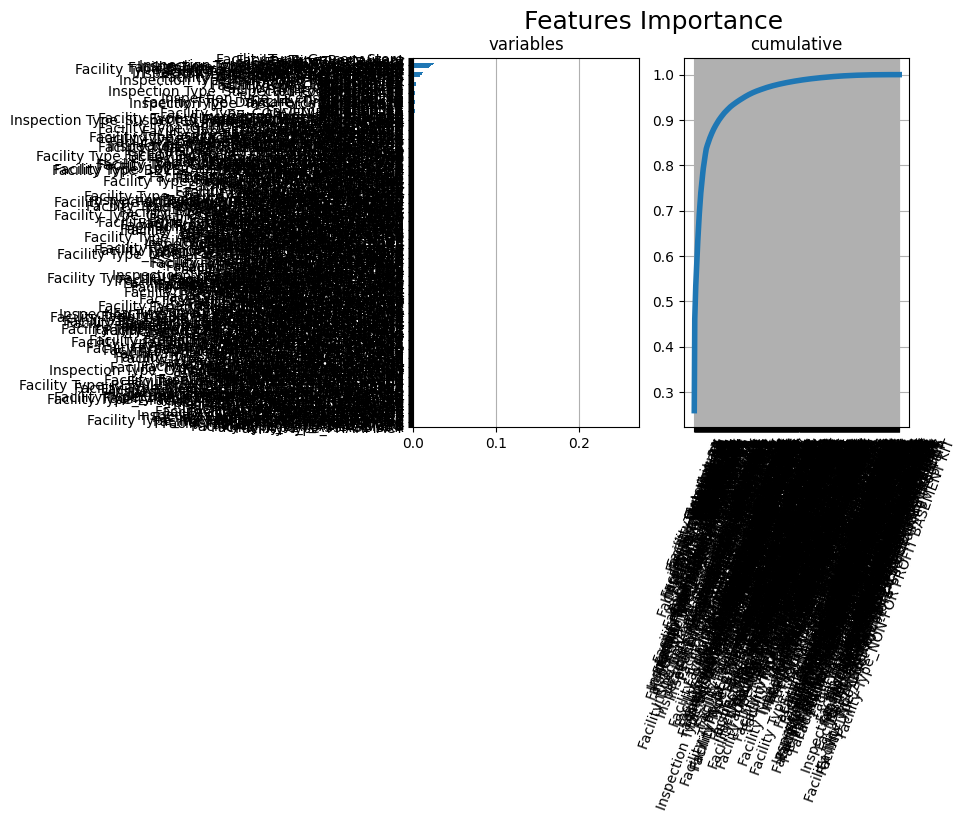

In [38]:
#borrowed from https://towardsdatascience.com/machine-learning-with-python-classification-complete-tutorial-d2c99dc524ec
X = df_train.iloc[:,1:]
y = df_train.iloc[:,0]
feature_names = df_train.columns[1:].tolist()
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas dtf
df_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
df_importances['cumsum'] = df_importances['IMPORTANCE'].cumsum(axis=0)
df_importances = df_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=18)
ax[0].title.set_text('variables')
df_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
df_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(df_importances)), 
          xticklabels=df_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [39]:
imp_features = df_importances[df_importances["cumsum"]<=0.9]
imp_features

,IMPORTANCE,cumsum
VARIABLE,,
Facility Type_Grocery Store,0.259007,0.259007
Facility Type_Restaurant,0.202321,0.461329
Facility Type_Liquor,0.039732,0.501061
Facility Type_Bakery,0.033244,0.534305
Inspection Type_Canvass,0.025325,0.559630
Inspection Type_License,0.024772,0.584402
Inspection Type_License Re-Inspection,0.024222,0.608625
Facility Type_School,0.024102,0.632727
Inspection Type_Short Form Complaint,0.021155,0.653882


In [42]:
imp_features.shape

(50, 2)

In [43]:
imp_features.index

Index(['Facility Type_Grocery Store', 'Facility Type_Restaurant',
       'Facility Type_Liquor', 'Facility Type_Bakery',
       'Inspection Type_Canvass', 'Inspection Type_License',
       'Inspection Type_License Re-Inspection', 'Facility Type_School',
       'Inspection Type_Short Form Complaint',
       'Facility Type_Children's Services Facility',
       'Facility Type_Daycare (2 - 6 Years)',
       'Facility Type_Daycare Above and Under 2 Years', 'Facility Type_TAVERN',
       'Facility Type_Mobile Food Dispenser',
       'Facility Type_Mobile Food Preparer',
       'Inspection Type_Canvass Re-Inspection', 'Facility Type_Wholesale',
       'Facility Type_Long Term Care', 'Inspection Type_Complaint',
       'Facility Type_Catering', 'Facility Type_Daycare Combo 1586',
       'Violation_21', 'Facility Type_GAS STATION',
       'Inspection Type_Complaint Re-Inspection', 'Violation_30',
       'Violation_31', 'Facility Type_Hospital', 'Violation_41',
       'Facility Type_LIVE POULTRY

In [ ]:
# X_names = ['Risk','Facility Type_Grocery Store', 'Facility Type_Restaurant',
#        'Inspection Type_Canvass', 'Violation_35', 'Violation_38',
#        'Violation_34', 'Violation_33', 'Year_2014', 'Year_2013',
#        'Inspection Type_License', 'Year_2015', 'Violation_32',
#        'Facility Type_Liquor', 'Year_2012', 'Year_2016', 'Year_2011',
#        'Inspection Type_Canvass Re-Inspection', 'Month_08',
#        'Facility Type_Bakery', 'Inspection Type_License Re-Inspection',
#        'Violation_41', 'Month_11', 'Month_07', 'Month_12', 'Month_09',
#        'Month_05', 'Inspection Type_Complaint', 'Month_10', 'Month_06',
#        'Violation_36', 'Month_04', 'Month_03', 'Day_14', 'Day_21', 'Day_17',
#        'Day_16', 'Inspection Type_Short Form Complaint', 'Day_15', 'Day_09',
#        'Month_01', 'Day_19', 'Violation_18', 'Day_05', 'Day_28', 'Day_18',
#        'Facility Type_School', 'Day_10', 'Day_06', 'Day_22', 'Day_23',
#        'Day_08', 'Day_07', 'Day_24', 'Month_02', 'Day_13', 'Day_20', 'Day_27',
#        'Day_03', 'Day_11', 'Day_29', 'Day_26', 'Day_02', 'Violation_40',
#        'Day_04', 'Day_25', 'Day_30', 'Day_12', 'Year_2017', 'Day_01',
#        'Inspection Type_Complaint Re-Inspection',
#        'Facility Type_Daycare (2 - 6 Years)','Violation_21',
#        'Facility Type_Daycare Above and Under 2 Years', 'Violation_30',
#        'Violation_37', 'Facility Type_TAVERN', 'Day_31',
#        'Facility Type_Mobile Food Dispenser', 'Violation_19']
# X_train = df_train[X_names].values
# y_train = df_train["Risk"].values
# X_test = df_test[X_names].values
# y_test = df_test["Risk"].values

In [44]:
X_train = df_train.iloc[:,1:].values
y_train = df_train["Risk"].values
X_test = df_test.iloc[:,1:].values
y_test = df_test["Risk"].values

In [45]:
X_train.shape, X_test.shape

((344815, 410), (147779, 410))

# Random Under Sampler

In [46]:
print("Before oversampling: ",Counter(y_train))
under_sampler = RandomUnderSampler(random_state=42)
X_train_RUS, y_train_RUS = under_sampler.fit_resample(X_train, y_train)

print("After oversampling: ",Counter(y_train_RUS))

Before oversampling:  Counter({1: 260497, 2: 66366, 3: 17952})
After oversampling:  Counter({1: 17952, 2: 17952, 3: 17952})


# Near Miss Under Sampler

In [47]:
print("Before oversampling: ",Counter(y_train))
under_sampler = NearMiss()
X_train_NM, y_train_NM = under_sampler.fit_resample(X_train, y_train)

print("After oversampling: ",Counter(y_train_NM))

Before oversampling:  Counter({1: 260497, 2: 66366, 3: 17952})
After oversampling:  Counter({1: 17952, 2: 17952, 3: 17952})


# Random Over Sampler

In [48]:
from imblearn.over_sampling import RandomOverSampler

print("Before oversampling: ",Counter(y_train))
over_sampler = RandomOverSampler(random_state=42)
X_train_ROS, y_train_ROS = over_sampler.fit_resample(X_train, y_train)

print("After oversampling: ",Counter(y_train_ROS))

Before oversampling:  Counter({1: 260497, 2: 66366, 3: 17952})
After oversampling:  Counter({1: 260497, 2: 260497, 3: 260497})


#SMOTE Over Sampler

In [49]:
print("Before oversampling: ",Counter(y_train))
SMOTE = SMOTE()

X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

print("After oversampling: ",Counter(y_train_SMOTE))

Before oversampling:  Counter({1: 260497, 2: 66366, 3: 17952})
After oversampling:  Counter({1: 260497, 2: 260497, 3: 260497})


# Gaussian Naive Bayes - Base Model

In [50]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((344815, 410), (344815,), (147779, 410), (147779,))

In [51]:
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(clf_gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(clf_gnb.score(X_test, y_test)))

# make a prediction
y_pred = clf_gnb.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
prediction_df_clf_gnb = pd.DataFrame(y_pred)

Accuracy of GNB classifier on training set: 0.26
Accuracy of GNB classifier on test set: 0.27
0.2657414111612611
[[ 9981 98807  2674]
 [  202 27012  1422]
 [   28  5375  2278]]
              precision    recall  f1-score   support

           1       0.98      0.09      0.16    111462
           2       0.21      0.94      0.34     28636
           3       0.36      0.30      0.32      7681

    accuracy                           0.27    147779
   macro avg       0.51      0.44      0.28    147779
weighted avg       0.80      0.27      0.21    147779



In [52]:
clf_gnb = GaussianNB()
clf_gnb.fit(X_train_RUS, y_train_RUS )
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(clf_gnb.score(X_train_RUS, y_train_RUS )))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(clf_gnb.score(X_test, y_test)))

# make a prediction
y_pred = clf_gnb.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
prediction_df_clf_gnb_RUS = pd.DataFrame(y_pred)

Accuracy of GNB classifier on training set: 0.40
Accuracy of GNB classifier on test set: 0.76
0.7642628519613748
[[110596    660    206]
 [ 27427   1014    195]
 [  6190    159   1332]]
              precision    recall  f1-score   support

           1       0.77      0.99      0.87    111462
           2       0.55      0.04      0.07     28636
           3       0.77      0.17      0.28      7681

    accuracy                           0.76    147779
   macro avg       0.70      0.40      0.40    147779
weighted avg       0.73      0.76      0.68    147779



In [53]:
clf_gnb = GaussianNB()
clf_gnb.fit(X_train_NM, y_train_NM)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(clf_gnb.score(X_train_NM, y_train_NM)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(clf_gnb.score(X_test, y_test)))

# make a prediction
y_pred = clf_gnb.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
prediction_df_clf_gnb_NW = pd.DataFrame(y_pred)

Accuracy of GNB classifier on training set: 0.39
Accuracy of GNB classifier on test set: 0.67
0.6730726287226196
[[96308  6270  8884]
 [24590  2051  1995]
 [ 5795   779  1107]]
              precision    recall  f1-score   support

           1       0.76      0.86      0.81    111462
           2       0.23      0.07      0.11     28636
           3       0.09      0.14      0.11      7681

    accuracy                           0.67    147779
   macro avg       0.36      0.36      0.34    147779
weighted avg       0.62      0.67      0.64    147779



In [54]:
clf_gnb = GaussianNB()
clf_gnb.fit(X_train_ROS, y_train_ROS )
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(clf_gnb.score(X_train_ROS, y_train_ROS )))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(clf_gnb.score(X_test, y_test)))

# make a prediction
y_pred = clf_gnb.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
prediction_df_clf_gnb_ROS = pd.DataFrame(y_pred)

Accuracy of GNB classifier on training set: 0.45
Accuracy of GNB classifier on test set: 0.26
0.2631970713024178
[[ 9508 99314  2640]
 [  144 27127  1365]
 [   27  5394  2260]]
              precision    recall  f1-score   support

           1       0.98      0.09      0.16    111462
           2       0.21      0.95      0.34     28636
           3       0.36      0.29      0.32      7681

    accuracy                           0.26    147779
   macro avg       0.52      0.44      0.27    147779
weighted avg       0.80      0.26      0.20    147779



In [55]:
clf_gnb = GaussianNB()
clf_gnb.fit(X_train_SMOTE, y_train_SMOTE)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(clf_gnb.score(X_train_SMOTE, y_train_SMOTE)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(clf_gnb.score(X_test, y_test)))

# make a prediction
y_pred = clf_gnb.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
prediction_df_clf_gnb_SMOTE = pd.DataFrame(y_pred)

Accuracy of GNB classifier on training set: 0.37
Accuracy of GNB classifier on test set: 0.76
0.7585719215856109
[[110651    771     40]
 [ 27497   1137      2]
 [  6218   1150    313]]
              precision    recall  f1-score   support

           1       0.77      0.99      0.87    111462
           2       0.37      0.04      0.07     28636
           3       0.88      0.04      0.08      7681

    accuracy                           0.76    147779
   macro avg       0.67      0.36      0.34    147779
weighted avg       0.70      0.76      0.67    147779



https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2

# Decision Tree

In [92]:
clf_DT = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf_DT.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf_DT.score(X_test, y_test)))

# make a prediction
y_pred = clf_DT.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
prediction_df_clf_DT = pd.DataFrame(y_pred)

Accuracy of Decision Tree classifier on training set: 0.79
Accuracy of Decision Tree classifier on test set: 0.79
0.7877370939037346
[[107316   3684    462]
 [ 21735   5478   1423]
 [  2056   2008   3617]]
              precision    recall  f1-score   support

           1       0.82      0.96      0.88    111462
           2       0.49      0.19      0.28     28636
           3       0.66      0.47      0.55      7681

    accuracy                           0.79    147779
   macro avg       0.66      0.54      0.57    147779
weighted avg       0.75      0.79      0.75    147779



In [93]:
prediction_df_clf_DT.columns = ["predictions"]
prediction_df_clf_DT["actuals"] = y_test
prediction_df_clf_DT["Inspection ID"] = df_test.index
prediction_df_clf_DT.head() 

,predictions,actuals,Inspection ID
0,1,1,547795
1,1,2,1527553
2,1,1,1439607
3,1,2,547586
4,1,1,363494


In [96]:
risk1_inspections = prediction_df_clf_DT[(prediction_df_clf_DT["predictions"] == 1) & (prediction_df_clf_DT["actuals"] == 1)]
risk1_inspections.head()

,predictions,actuals,Inspection ID
0,1,1,547795
2,1,1,1439607
4,1,1,363494
6,1,1,1372501
7,1,1,1391421


In [101]:
Risk_1_df = pd.merge(risk3_inspections, data, on = "Inspection ID", how="left")
Risk_1_df.head()

,predictions,actuals,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,1,1,547795,GRECIA'S PIZZA,GRECIA'S PIZZA,2069362.0,Restaurant,Risk 1 (High),2147 S PULASKI RD,CHICAGO,IL,60623.0,11/01/2011,Canvass Re-Inspection,Pass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.851868,-87.724621,"(41.85186783555786, -87.72462059411542)"
1,1,1,1439607,FLACO'S TACOS,FLACO'S TACOS,2049605.0,Restaurant,Risk 1 (High),46 E CHICAGO AVE,CHICAGO,IL,60611.0,11/10/2014,Canvass,Pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.896811,-87.626449,"(41.89681130646016, -87.6264488028737)"
2,1,1,363494,BLANCO & NEGRO RESTAURANT,BLANCO & NEGRO RESTAURANT,1954915.0,Restaurant,Risk 1 (High),4043 W 26TH ST,CHICAGO,IL,60623.0,01/20/2011,Canvass Re-Inspection,Pass,"26. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, P...",41.844121,-87.726213,"(41.84412068159105, -87.72621334457627)"
3,1,1,1372501,PITA EXPRESS,PITA EXPRESS,52356.0,Restaurant,Risk 1 (High),100 W RANDOLPH ST,CHICAGO,IL,60601.0,04/29/2014,Complaint Re-Inspection,Fail,"10. SEWAGE AND WASTE WATER DISPOSAL, NO BACK S...",41.884586,-87.631010,"(41.88458626715456, -87.63101044588599)"
4,1,1,1391421,JARVIS GYROS,JARVIS GYROS GRILL,2177795.0,Restaurant,Risk 1 (High),1517 W JARVIS AVE,CHICAGO,IL,60626.0,02/20/2014,Complaint,Pass,42. APPROPRIATE METHOD OF HANDLING OF FOOD (IC...,42.015929,-87.668848,"(42.015929221479176, -87.66884761052985)"


In [105]:
Risk1_establishments = Risk_1_df["DBA Name"].unique()
Risk1_establishments

array(["GRECIA'S PIZZA", "FLACO'S TACOS", 'BLANCO & NEGRO RESTAURANT',
       ..., 'CAFE ORIENT 33', 'GABOS RESTAURANT', 'BLUE DOOR FARM STAND'],
      dtype=object)

In [106]:
Risk1_establishments[:10]

array(["GRECIA'S PIZZA", "FLACO'S TACOS", 'BLANCO & NEGRO RESTAURANT',
       'PITA EXPRESS', 'JARVIS GYROS', "JOE'S SEAFOOD, PRIME STEAK",
       'REGGAE ISLAND JERK CHICKEN, INC', 'ANMOL RESTAURANT',
       'PIZZERIA CALZONE', "BACINO'S OF LINCOLN PARK LTD"], dtype=object)

In [104]:
data["DBA Name"].nunique()

17590

In [103]:
Risk_1_df["DBA Name"].nunique()

10562

In [57]:
clf_DT = DecisionTreeClassifier().fit(X_train_RUS, y_train_RUS )
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf_DT.score(X_train_RUS, y_train_RUS )))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf_DT.score(X_test, y_test)))

# make a prediction
y_pred = clf_DT.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
prediction_df_clf_DT_RUS = pd.DataFrame(y_pred)

Accuracy of Decision Tree classifier on training set: 0.68
Accuracy of Decision Tree classifier on test set: 0.68
0.6752583249311472
[[83252 21132  7078]
 [11695  9590  7351]
 [  349   385  6947]]
              precision    recall  f1-score   support

           1       0.87      0.75      0.81    111462
           2       0.31      0.33      0.32     28636
           3       0.32      0.90      0.48      7681

    accuracy                           0.68    147779
   macro avg       0.50      0.66      0.53    147779
weighted avg       0.74      0.68      0.69    147779



In [58]:
clf_DT = DecisionTreeClassifier().fit(X_train_NM, y_train_NM)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf_DT.score(X_train_NM, y_train_NM)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf_DT.score(X_test, y_test)))

# make a prediction
y_pred = clf_DT.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
prediction_df_clf_DT_NW = pd.DataFrame(y_pred)

Accuracy of Decision Tree classifier on training set: 0.63
Accuracy of Decision Tree classifier on test set: 0.52
0.5197220173366988
[[64393 13207 33862]
 [10255  5665 12716]
 [  252   683  6746]]
              precision    recall  f1-score   support

           1       0.86      0.58      0.69    111462
           2       0.29      0.20      0.24     28636
           3       0.13      0.88      0.22      7681

    accuracy                           0.52    147779
   macro avg       0.43      0.55      0.38    147779
weighted avg       0.71      0.52      0.58    147779



In [59]:
clf_DT = DecisionTreeClassifier().fit(X_train_ROS, y_train_ROS)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf_DT.score(X_train_ROS, y_train_ROS)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf_DT.score(X_test, y_test)))

# make a prediction
y_pred = clf_DT.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
prediction_df_clf_DT_ROS = pd.DataFrame(y_pred)

Accuracy of Decision Tree classifier on training set: 0.68
Accuracy of Decision Tree classifier on test set: 0.67
0.666346368563869
[[81122 23352  6988]
 [10841 10396  7399]
 [  319   408  6954]]
              precision    recall  f1-score   support

           1       0.88      0.73      0.80    111462
           2       0.30      0.36      0.33     28636
           3       0.33      0.91      0.48      7681

    accuracy                           0.67    147779
   macro avg       0.50      0.67      0.54    147779
weighted avg       0.74      0.67      0.69    147779



In [62]:
clf_DT = DecisionTreeClassifier().fit(X_train_SMOTE, y_train_SMOTE)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf_DT.score(X_train_SMOTE, y_train_SMOTE)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf_DT.score(X_test, y_test)))

y_pred = clf_DT.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
prediction_df_clf_DT_SMOTE = pd.DataFrame(y_pred)

Accuracy of Decision Tree classifier on training set: 0.68
Accuracy of Decision Tree classifier on test set: 0.66
0.6624283558557035
[[80202 24651  6609]
 [10593 10840  7203]
 [  351   479  6851]]
              precision    recall  f1-score   support

           1       0.88      0.72      0.79    111462
           2       0.30      0.38      0.34     28636
           3       0.33      0.89      0.48      7681

    accuracy                           0.66    147779
   macro avg       0.50      0.66      0.54    147779
weighted avg       0.74      0.66      0.69    147779



# Neural Networks model

In [61]:
def baseline_model():
    model = Sequential()
    model.add(Dense(8, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 

estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=20, verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
prediction_df_model1 = pd.DataFrame(y_pred)

<ipython-input-61-8c1562e61eec>:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=20, verbose=0)


Baseline: 78.91% (0.22%)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.7869859722964697
[[107220   3779    463]
 [ 21703   5486   1447]
 [  2080   2007   3594]]
              precision    recall  f1-score   support

           1       0.82      0.96      0.88    111462
           2       0.49      0.19      0.27     28636
           3       0.65      0.47      0.55      7681

    accuracy                           0.79    147779
   macro avg       0.65      0.54      0.57    147779
weighted avg       0.75      0.79      0.75    147779



In [ ]:
# --The End--